In [3]:
import imageio 
import numpy as np
import matplotlib.pyplot as plt
import cv2
# %matplotlib widget
import sys
from scipy import sparse
from skimage.measure import profile_line
import pandas as pd
from tqdm.autonotebook import tqdm
import networkx as nx
import pandas as pd
from collections import Counter

In [4]:
def order_pixel(pixel_begin, pixel_end, pixel_list):
    def get_neighbours(pixel):
        x = pixel[0]
        y = pixel[1]
        primary_neighbours = {(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)}
        secondary_neighbours = {
            (x + 1, y - 1),
            (x + 1, y + 1),
            (x - 1, y + 1),
            (x - 1, y - 1),
        }
        num_neighbours = 0
        actual_neighbours = set()
        for neighbour in primary_neighbours:
            if neighbour in pixel_list:
                xp = neighbour[0]
                yp = neighbour[1]
                primary_neighboursp = {
                    (xp + 1, yp),
                    (xp - 1, yp),
                    (xp, yp + 1),
                    (xp, yp - 1),
                }
                for neighbourp in primary_neighboursp:
                    secondary_neighbours.discard(neighbourp)
                actual_neighbours.add(neighbour)
        for neighbour in secondary_neighbours:
            if neighbour in pixel_list:
                actual_neighbours.add(neighbour)
        return actual_neighbours

    ordered_list = [pixel_begin]
    current_pixel = pixel_begin
    precedent_pixel = pixel_begin
    while current_pixel != pixel_end:
        neighbours = get_neighbours(current_pixel)
        neighbours.discard(precedent_pixel)
        precedent_pixel = current_pixel
        current_pixel = neighbours.pop()
        ordered_list.append(current_pixel)
    return ordered_list


def extract_branches(doc_skel):
    def get_neighbours(pixel):
        x = pixel[0]
        y = pixel[1]
        primary_neighbours = {(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)}
        secondary_neighbours = {
            (x + 1, y - 1),
            (x + 1, y + 1),
            (x - 1, y + 1),
            (x - 1, y - 1),
        }
        num_neighbours = 0
        actual_neighbours = []
        for neighbour in primary_neighbours:
            if neighbour in non_zero_pixel:
                num_neighbours += 1
                xp = neighbour[0]
                yp = neighbour[1]
                primary_neighboursp = {
                    (xp + 1, yp),
                    (xp - 1, yp),
                    (xp, yp + 1),
                    (xp, yp - 1),
                }
                for neighbourp in primary_neighboursp:
                    secondary_neighbours.discard(neighbourp)
                actual_neighbours.append(neighbour)
        for neighbour in secondary_neighbours:
            if neighbour in non_zero_pixel:
                num_neighbours += 1
                actual_neighbours.append(neighbour)
        return (actual_neighbours, num_neighbours)

    pixel_branch_dic = {pixel: set() for pixel in doc_skel.keys()}
    is_node = {pixel: False for pixel in doc_skel.keys()}
    pixel_set = set(doc_skel.keys())
    non_zero_pixel = doc_skel
    new_index = 1
    non_explored_direction = set()
    while len(pixel_set) > 0:
        is_new_start = len(non_explored_direction) == 0
        if is_new_start:
            pixel = pixel_set.pop()
        else:
            pixel = non_explored_direction.pop()
        actual_neighbours, num_neighbours = get_neighbours(pixel)
        if is_new_start:
            if num_neighbours == 2:
                new_index += 1
                pixel_branch_dic[pixel] = {new_index}
        is_node[pixel] = num_neighbours in [0, 1, 3, 4]
        pixel_set.discard(pixel)
        #!!! This is to solve the two neighbours nodes problem
        if is_node[pixel]:
            for neighbour in actual_neighbours:
                if is_node[neighbour]:
                    new_index += 1
                    pixel_branch_dic[pixel].add(new_index)
                    pixel_branch_dic[neighbour].add(new_index)
            continue
        else:
            for neighbour in actual_neighbours:
                if neighbour in pixel_set:
                    non_explored_direction.add(neighbour)
                pixel_branch_dic[neighbour] = pixel_branch_dic[neighbour].union(
                    pixel_branch_dic[pixel]
                )
    return (pixel_branch_dic, is_node, new_index)

def generate_set_node(graph_tab):
    nodes = set()
    for index, row in graph_tab.iterrows():
        nodes.add(row["origin"])
        nodes.add(row["end"])
    return sorted(nodes)


def generate_nx_graph(graph_tab, labeled=False):
    G = nx.Graph()
    pos = {}
    if not labeled:
        nodes = generate_set_node(graph_tab)
    for index, row in graph_tab.iterrows():
        if labeled:
            identifier1 = row["origin_label"]
            identifier2 = row["end_label"]
            pos[identifier1] = np.array(row["origin_pos"]).astype(np.int)
            pos[identifier2] = np.array(row["end_pos"]).astype(np.int)
        else:
            identifier1 = nodes.index(row["origin"])
            identifier2 = nodes.index(row["end"])
            pos[identifier1] = np.array(row["origin"]).astype(np.int)
            pos[identifier2] = np.array(row["end"]).astype(np.int)
        info = {"weight": len(row["pixel_list"]), "pixel_list": row["pixel_list"]}
        G.add_edges_from([(identifier1, identifier2, info)])
    return (G, pos)

def from_sparse_to_graph(doc_skel):
    column_names = ["origin", "end", "pixel_list"]
    graph = pd.DataFrame(columns=column_names)
    pixel_branch_dic, is_node, new_index = extract_branches(doc_skel)
    nodes = []
    edges = {}
    for pixel in pixel_branch_dic:
        for branch in pixel_branch_dic[pixel]:
            right_branch = branch
            if right_branch not in edges.keys():
                edges[right_branch] = {"origin": [], "end": [], "pixel_list": [[]]}
            if is_node[pixel]:
                if len(edges[right_branch]["origin"]) == 0:
                    edges[right_branch]["origin"] = [pixel]
                else:
                    edges[right_branch]["end"] = [pixel]
            edges[right_branch]["pixel_list"][0].append(pixel)
    for branch in edges:
        if len(edges[branch]["origin"]) > 0 and len(edges[branch]["end"]) > 0:
            graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)
    for index, row in graph.iterrows():
        row["pixel_list"] = order_pixel(row["origin"], row["end"], row["pixel_list"])
    return graph


In [6]:
# from amftrack.pipeline.functions.image_processing.extract_width_fun import *
pixel_conversion_factor = 1/12.3
# pixel_conversion_factor = 1

def get_width_pixel(edge,index,im,pivot,before,after,size = 20,width_factor = 10,averaging_size = 100,threshold_averaging = 10):
    imtab=im
    orientation=np.array(before)-np.array(after)
    perpendicular = [1,-orientation[0]/orientation[1]] if orientation[1]!=0 else [0,1]
    perpendicular_norm=np.array(perpendicular)/np.sqrt(perpendicular[0]**2+perpendicular[1]**2)
    point1=np.around(np.array(pivot)+width_factor*perpendicular_norm)
    point2=np.around(np.array(pivot)-width_factor*perpendicular_norm)
    point1=point1.astype(int)
    point2=point2.astype(int)
    p = profile_line(imtab, point1, point2,mode='constant')
    xdata = np.array(range(len(p)))
    ydata = np.array(p)
#     print(p)
    background = 0.5
    arg = len(p)//2
    l1,l2 = [i+arg for i in range(len(p[arg:])) if p[arg+i]==255],[arg-i for i in range(len(p[:arg])) if p[arg-i]==255]
    if len(l1)==0 or len(l2)==0:
        return(-1)
    else:
        arg_max = min(l1)
        arg_min = max(l2)
        width_pix = arg_max-arg_min
        return(width_pix)

def get_width_edge(edge,graph,im,resolution,local=False, threshold_averaging = 10):
    pixel_list = graph.get_edge_data(edge[0], edge[1])["pixel_list"]
    pixels = []
    indexes = []
    poss = []
    widths={}
    if len(pixel_list)>3*resolution:
        for i in range(0,len(pixel_list)//resolution):
            index = i*resolution
            indexes.append(index)
            pixel = pixel_list[index]
            pixels.append(pixel)
            poss.append(pixel)
    else:
        indexes = [0,len(pixel_list)//2,len(pixel_list)-1]
        for index in indexes:
            pixel = pixel_list[index]
            pixels.append(pixel)
            poss.append(pixel)
#     print(indexes)
    for i, index in enumerate(indexes[1:-1]):
        source_img = im
        pivot = poss[i+1]
        before = poss[i]
        after = poss[i+2]
        width = get_width_pixel(edge,index,source_img,pivot,before,after,threshold_averaging = threshold_averaging)
        widths[pixel_list[index]]=-1 if width==-1 else width*pixel_conversion_factor 
    return(widths)    

def get_length_um(edge,graph):
    pixels = graph.get_edge_data(edge[0], edge[1])["pixel_list"]
    length_edge = 0
    for i in range(len(pixels) // 10 + 1):
        if i * 10 <= len(pixels) - 1:
            length_edge += np.linalg.norm(
                np.array(pixels[i * 10])
                - np.array(pixels[min((i + 1) * 10, len(pixels) - 1)])
            )
    #         length_edge+=np.linalg.norm(np.array(pixels[len(pixels)//10-1*10-1])-np.array(pixels[-1]))
    return length_edge * pixel_conversion_factor

def get_width_info(graph,im,resolution = 10):
    edge_width={}
    for edge in graph.edges:
        list_widths = list(get_width_edge(edge,graph,im,resolution).values()) 
        mean = -1 if -1 in list_widths else np.mean(list_widths)
        edge_width[edge]=mean
    return(edge_width)

def get_length_info(graph,im,resolution = 10):
    edge_length={}
    for edge in graph.edges:
        edge_length[edge]=get_length_um(edge,graph)
    return(edge_length)

In [7]:
def analyse_root_img(paths):
    begin=[]
    end = []
    begin_pos = []
    end_pos = []
    length = []
    width = []
    ids = []
    with tqdm(total=len(paths), desc="analyzing roots", leave=False) as pbar:
        for path in paths:
            path_relative = path.split("\\")[-1]
            im = imageio.imread(path)  
            gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)   
            skeletonized = cv2.ximgproc.thinning(255-gray)
            skeleton = sparse.dok_matrix(skeletonized)
            nx_graph, pos = generate_nx_graph(from_sparse_to_graph(skeleton))
            width_info = get_width_info(nx_graph,gray)
            length_info = get_length_info(nx_graph,gray)    
            canva = np.zeros((*gray.shape,4))
            for edge in width_info.keys():
                pixel_list = nx_graph.get_edge_data(edge[0], edge[1])["pixel_list"]
                for pixel in pixel_list:
                    canva[pixel[0],pixel[1],:] = np.array(plt.get_cmap('jet')(int(400*width_info[edge])))
            plt.close("all")
            plt.clf()
            fig, ax = plt.subplots()
            kernel = np.ones((5,5),np.uint8)

            ax.imshow(cv2.dilate(canva,kernel,iterations = 1))
            ax.imshow(gray,alpha = 0.2)
            plt.savefig('extracted/'+path_relative.split('.')[0]+'_overlay.png',dpi=300)
            for edge in nx_graph.edges:
                begin.append(edge[0])
                end.append(edge[1])
                begin_pos.append(pos[edge[0]])
                end_pos.append(pos[edge[1]])    
                length.append(length_info[edge])
                width.append(width_info[edge])
                ids.append(path_relative)
            pbar.update(1)
    data = pd.DataFrame(np.array((ids,begin,end,begin_pos,end_pos,length,width)).transpose(),columns=['id','begin','end','begin_pos','end_pos','length','width'])
    data.to_csv('width_length_total.csv')    

***If you select the right path, this should work*** 

Extracted images should be saved in extracted in the same folder...
Adapt paths according to you environment...

In [9]:
from os import listdir
from os.path import isfile, join
mypath = 'Roots_Coco'
paths = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
print(len(paths))
# paths = [path for path in paths if not isfile('extracted/'+path.split("\\")[-1].split('.')[0]+'_overlay.png')]
# len(paths)

464


analyzing roots:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\coren\anaconda3\envs\cleanMsc\lib\site-packages\ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


<Figure size 432x288 with 0 Axes>

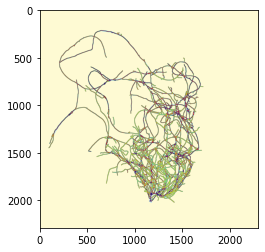

In [10]:
analyse_root_img(paths[:1])

In [9]:
plt.close("all")
fig, ax = plt.subplots()
ax.imshow(gray)
# for node in pos.keys():
#     ax.scatter(pos[node][1],pos[node][0])    
for edge in width_info.keys():
    ax.plot((pos[edge[0]][1],pos[edge[1]][1]),(pos[edge[0]][0],pos[edge[1]][0]),color = plt.get_cmap('jet')(int(20*width_info[edge])))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [87]:
canva = np.zeros((*gray.shape,4))
for edge in width_info.keys():
    pixel_list = nx_graph.get_edge_data(edge[0], edge[1])["pixel_list"]
    for pixel in pixel_list:
        canva[pixel[0],pixel[1],:] = np.array(plt.get_cmap('jet')(int(20*width_info[edge])))

In [86]:
plt.close("all")
fig, ax = plt.subplots()
kernel = np.ones((5,5),np.uint8)

ax.imshow(cv2.dilate(canva,kernel,iterations = 1))
ax.imshow(gray,alpha = 0.2)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …